# DATA 441 Module 1 - Section 2

<font face="Chalkboard" color="darkgreen" size=10>Lowess - How Does the Method Generalize</font>


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

https://towardsdatascience.com/loess-373d43b03564

https://xavierbourretsicotte.github.io/loess.html

## A Framework Based on Linear Regression

The main idea of linear regression is the assumption that:

$$\large y = X\cdot\beta +\sigma\epsilon $$

If we pre-multiply this equation with a matrix of weights (the "weights" of observation $i$ are on the main diagonal and the rest of the elements are 0) we get:

$$\large \text{diag}(W(i))y = \text{diag}(W(i))X\cdot\beta +\sigma \text{diag}(W(i))\epsilon $$

The independent observations are the rows of the matrix $X$. Each row has a number of columns (this is the number of features) and we can denote it by $p.$ As such, every row is a vector in $\mathbb{R}^p.$ 

We shall have $n$ different weight vectors because we have $n$ different observations.

**Important aspect**: linear regression can be seen as a linear combination of the observed outputs (values of the dependent variable).

We have:

$$\large  X^Ty = X^TX\beta +\sigma X^T\epsilon$$

We solve for $\beta$ (by assuming that $X^TX$ is invertible):

$$\large \beta = (X^TX)^{-1}(X^Ty) - \sigma (X^TX)^{-1}X^T\epsilon$$

We take the expected value of this equation and obtain the expected value of the coeffcients:

$$\large \bar{\beta} = (X^TX)^{-1}(X^Ty)$$

Therefore the predictions we make are:

$$\large \hat{y} = X(X^TX)^{-1}(X^Ty)$$

For the locally weighted regression we have 

$$\large \hat{y} = X(X^TWX)^{-1}(X^TWy)$$

The Big Idea: the predictions we make are a linear combination of the actual observed values of the dependent variable!

For locally weighted regression, $\hat{y}$ is obtained as a different linear combination of the values of y.

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import statsmodels.api as sm
from math import ceil
from scipy import linalg
from IPython.display import Image
from IPython.display import display
plt.style.use('seaborn-white')

In [7]:
A = np.array([[2,3],[5,4]])
A # is it invertable? Yes. Determinate is not 0.

array([[2, 3],
       [5, 4]])

In [8]:
# Compute the determinate with numpy 
np.linalg.det(A)

-6.999999999999999

In [9]:
np.transpose(A)

array([[2, 5],
       [3, 4]])

In [10]:
# matrix product A^T and A
np.transpose(A).dot(A)

array([[29, 26],
       [26, 25]])

In [11]:
B = np.linalg.inv(A)
B

array([[-0.57142857,  0.42857143],
       [ 0.71428571, -0.28571429]])

In [12]:
A.dot(B)

array([[1.00000000e+00, 5.55111512e-17],
       [4.44089210e-16, 1.00000000e+00]])


The following animations are from the scikit-lego documentation:

<figure>
<center>
<img src='https://drive.google.com/uc?id=1bQmo-j35etyEWt7Ce8TSo01YSOhZQBeY'width='800px'/>
<figcaption>Example of how weights work</figcaption></center>
</figure>




## Different Kernels

Definition of the kernels: https://en.wikipedia.org/wiki/Kernel_(statistics)

There are many choices of kernels for locally weighted regression. The idea is to have a function with one local maximum that has a compact support.

1.   The Exponential Kernel

$$ K(x):= e^{-\frac{\|x\|^2}{2}}$$


2.   The Tricubic Kernel

$$ K(x):=\begin{cases}
(1-\|x\|^3)^3 \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$

3.   The Epanechnikov Kernel

$$ K(x):=\begin{cases}
\frac{3}{4}(1-\|x\|^2) \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$

3.   The Quartic Kernel

$$ K(x):=\begin{cases}
\frac{15}{16}(1-\|x\|^2)^2 \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$


In [13]:
# What if we code a kernel function naiavely?

def tricube(x):
    if np.abs(x)<1:
        return (1-np.abs(x)**3)**3
    else:
        return 0


In [14]:
h = np.vectorize(tricube)
h([.5,2,3])

array([0.66992188, 0.        , 0.        ])

In [15]:
# this is the correct vectorized version
def tricubic(x):
  return np.where(np.abs(x)>1,0,(1-np.abs(x)**3)**3)         

In [16]:
x = np.linspace(-1,1,201)
y = tricubic(x)

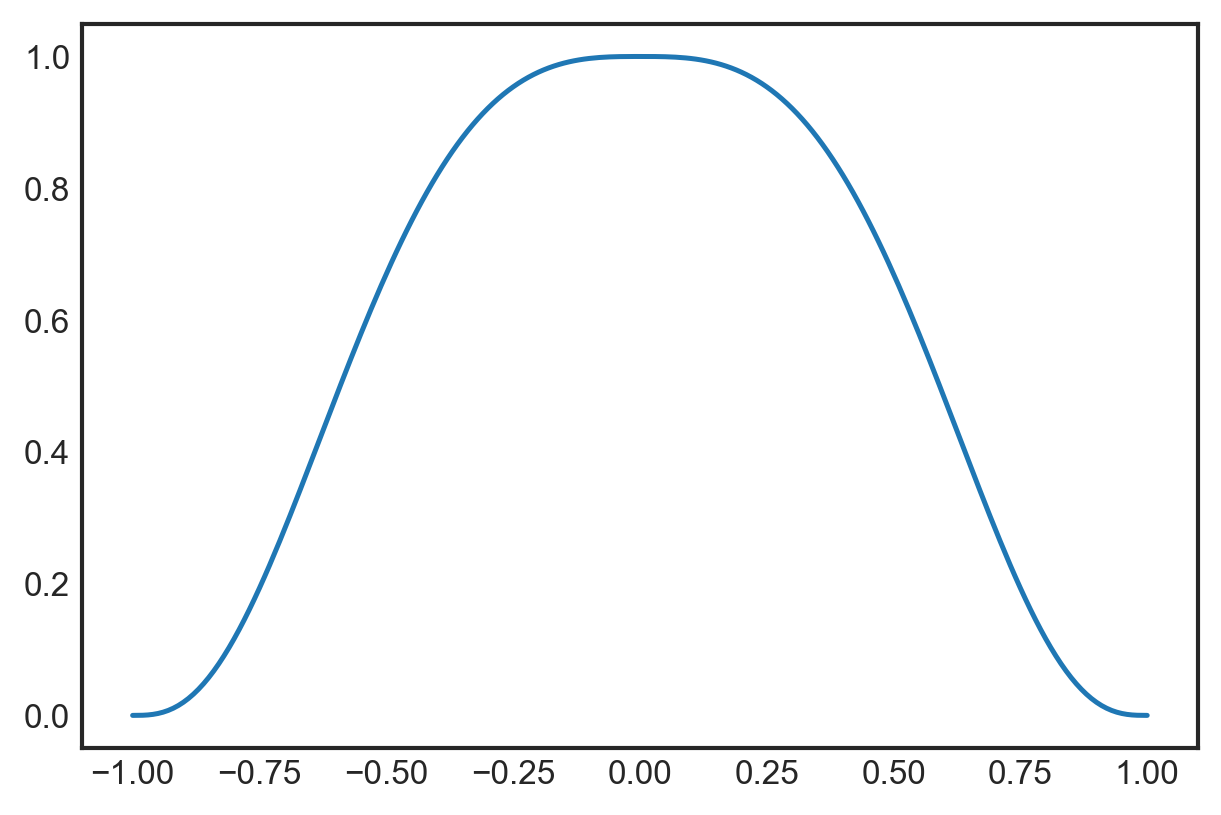

In [17]:
plt.plot(x,y)
plt.show()

In [18]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2)) 

In [19]:
y = Epanechnikov(x)

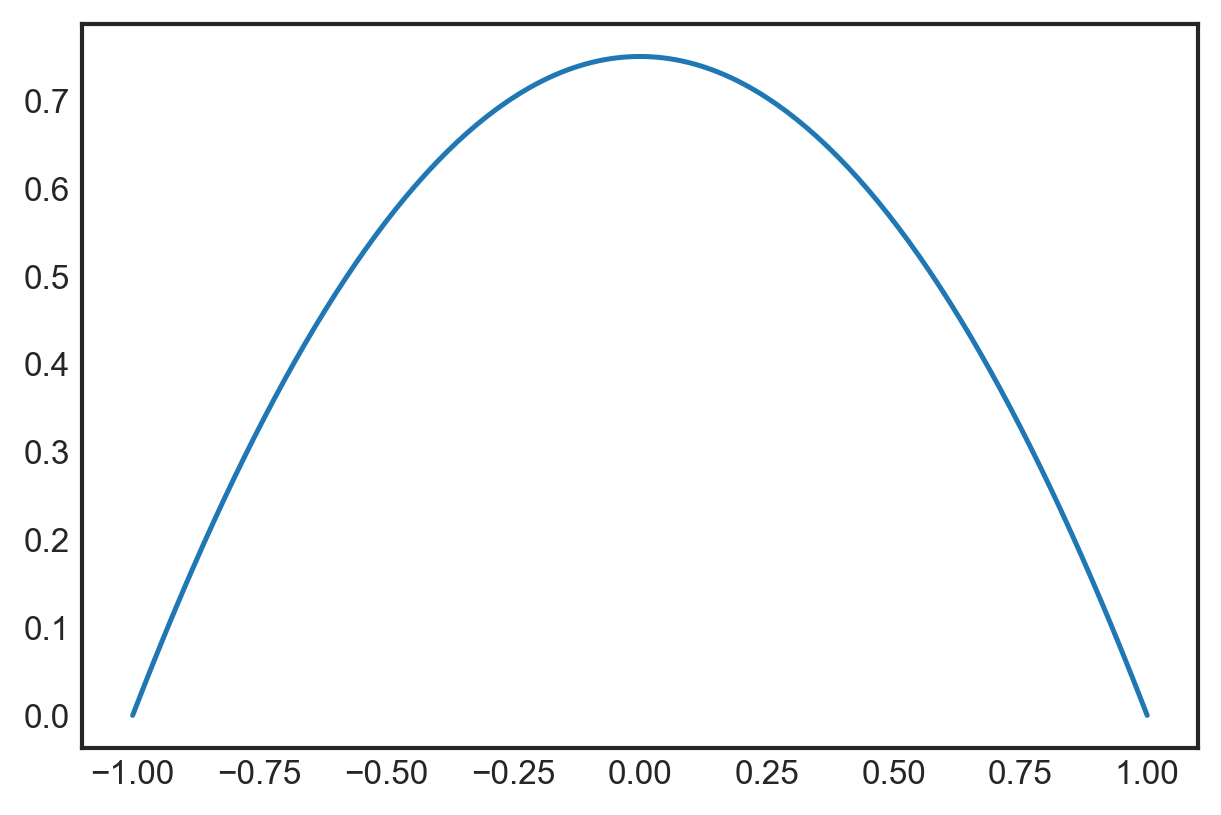

In [20]:
plt.plot(x,y)
plt.show()

## A Nonlinear Example

In [21]:
lm = LinearRegression()

In [22]:
kernel = tricubic

In [23]:
def kernel_function(xi,x0,kern, tau): 
    return kern((xi - x0)/(2*tau))

In [24]:
def weights_matrix(x,kern,tau):
  n = len(x)
  return np.array([kernel_function(x,x[i],kern,tau) for i in range(n)]) 

In [58]:
n = len(x)
w = weights_matrix(x,kernel,0.05)

In [60]:
for i in range(n):
    weights = w[:, i]
    lm.fit(np.diag(w[:,i]).dot(x.reshape(-1,1)),np.diag(w[:,i]).dot(y.reshape(-1,1)))
    yest[i] = lm.predict(x[i].reshape(-1,1)) 

In [85]:
def lowess(x, y, kern, tau=0.05):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # tau is a hyper-parameter
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        beta = linalg.solve(A, b) # A*beta = b
        # beta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = beta[0] + beta[1] * x[i] 

    return yest

In [64]:
def lowess(x, y, kern, tau=0.05):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # tau is a hyper-parameter
    n = len(x)
    yest = np.zeros(n)
    
    #Initializing all weights from the bell shape kernel function       
    #Looping through all x-points
    
    w = weights_matrix(x,kern,tau)    
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        lm.fit(np.diag(w[:,i]).dot(x.reshape(-1,1)),np.diag(w[:,i]).dot(y.reshape(-1,1)))
        yest[i] = lm.predict(x[i].reshape(-1,1)) 

    return yest

In [30]:
# approach by Alex Gramfort

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

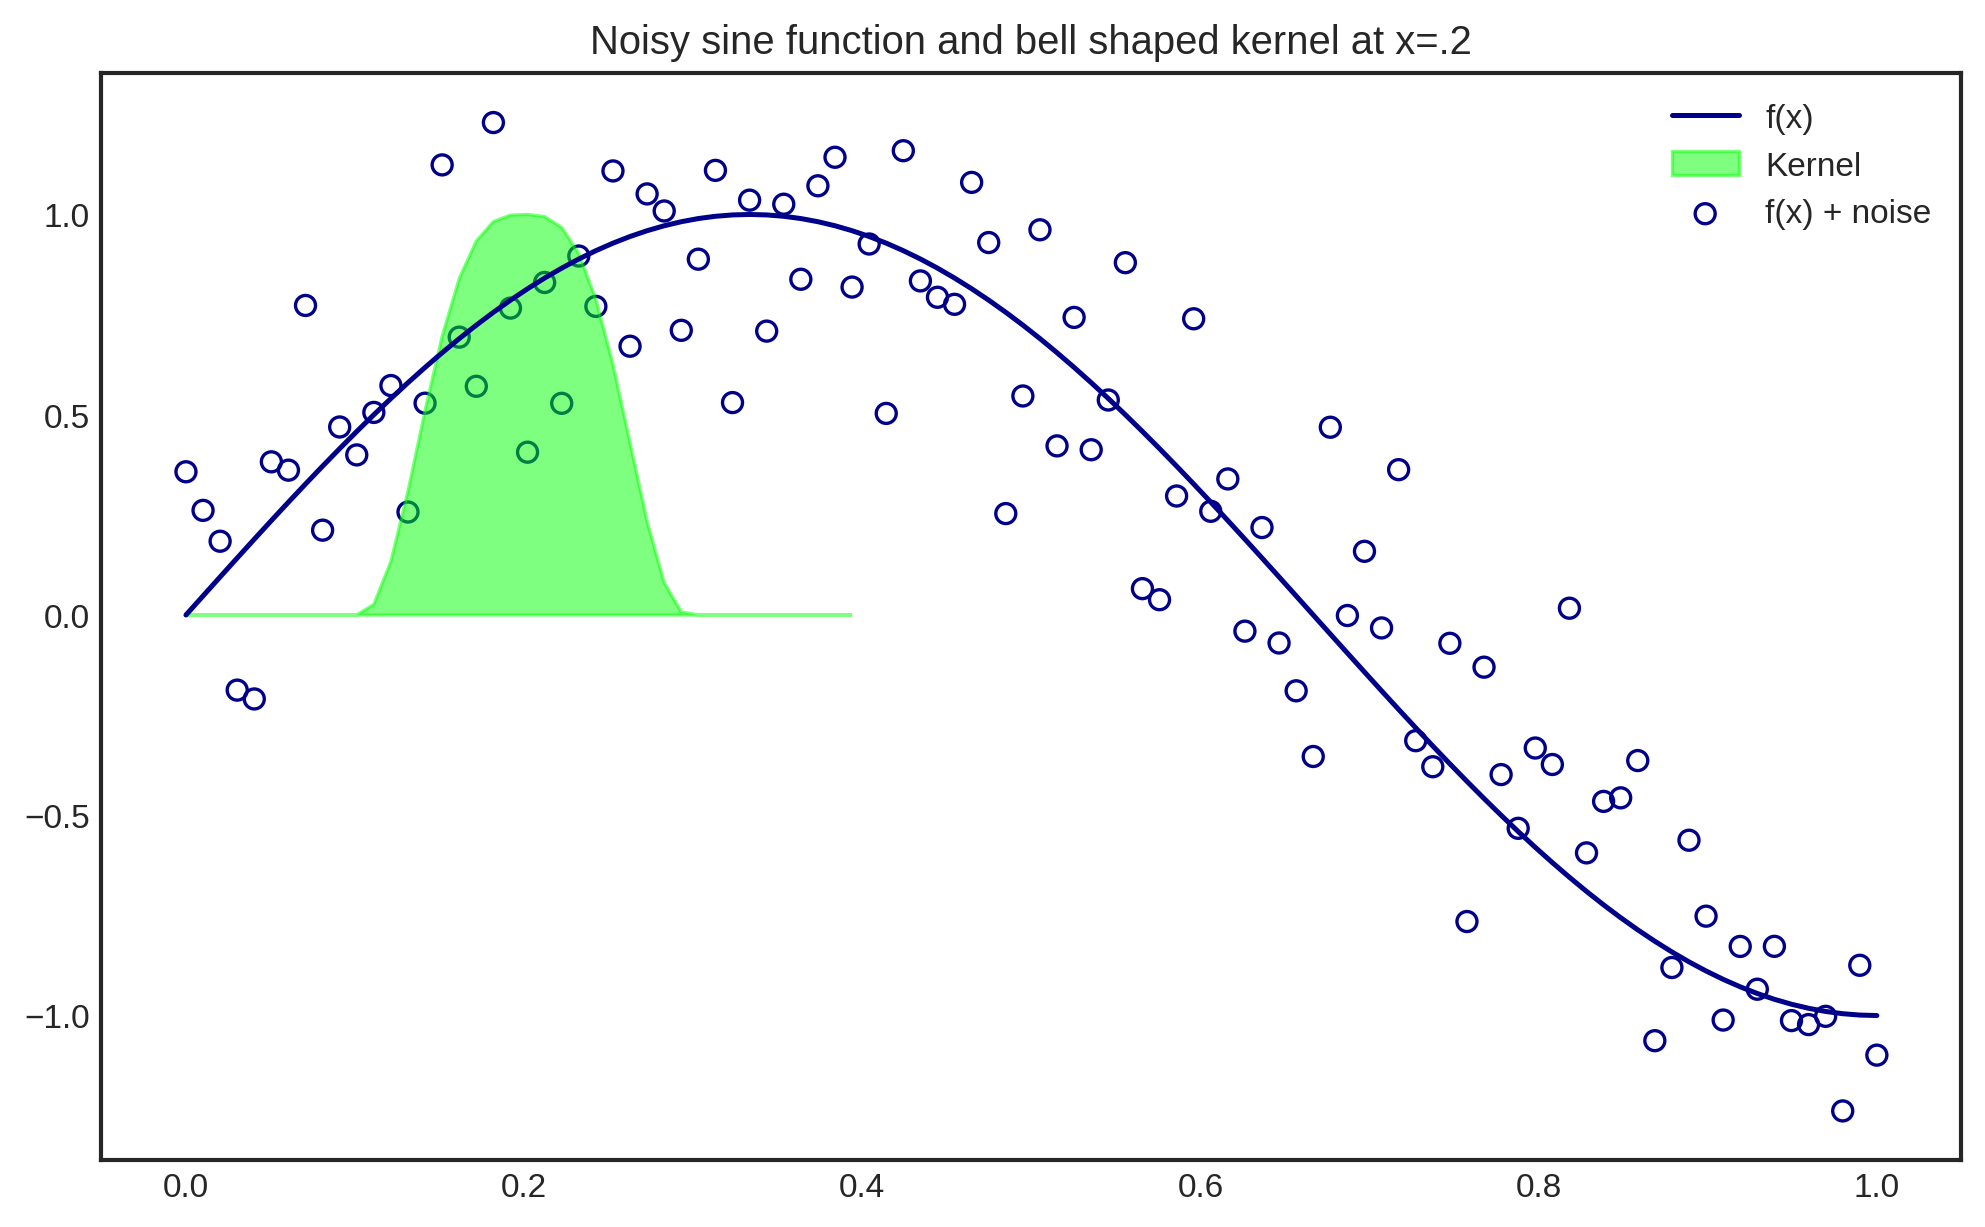

In [86]:
#Initializing noisy non linear data
x = np.linspace(0,1,100)
noise = np.random.normal(loc = 0, scale = .25, size = 100)
y = np.sin(x * 1.5 * np.pi ) 
y_noise = y + noise

#Plotting the noisy data and the kernell at around x = 0.2
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'f(x)')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'f(x) + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,kernel,.05), color = 'lime', alpha = .5, label = 'Kernel')
plt.legend()
plt.title('Noisy sine function and bell shaped kernel at x=.2')
plt.show()

In [87]:
f = 0.25
yest1 = lowess_ag(x, y, f=f, iter=3)
yest2 = lowess(x,y,kernel,0.04)

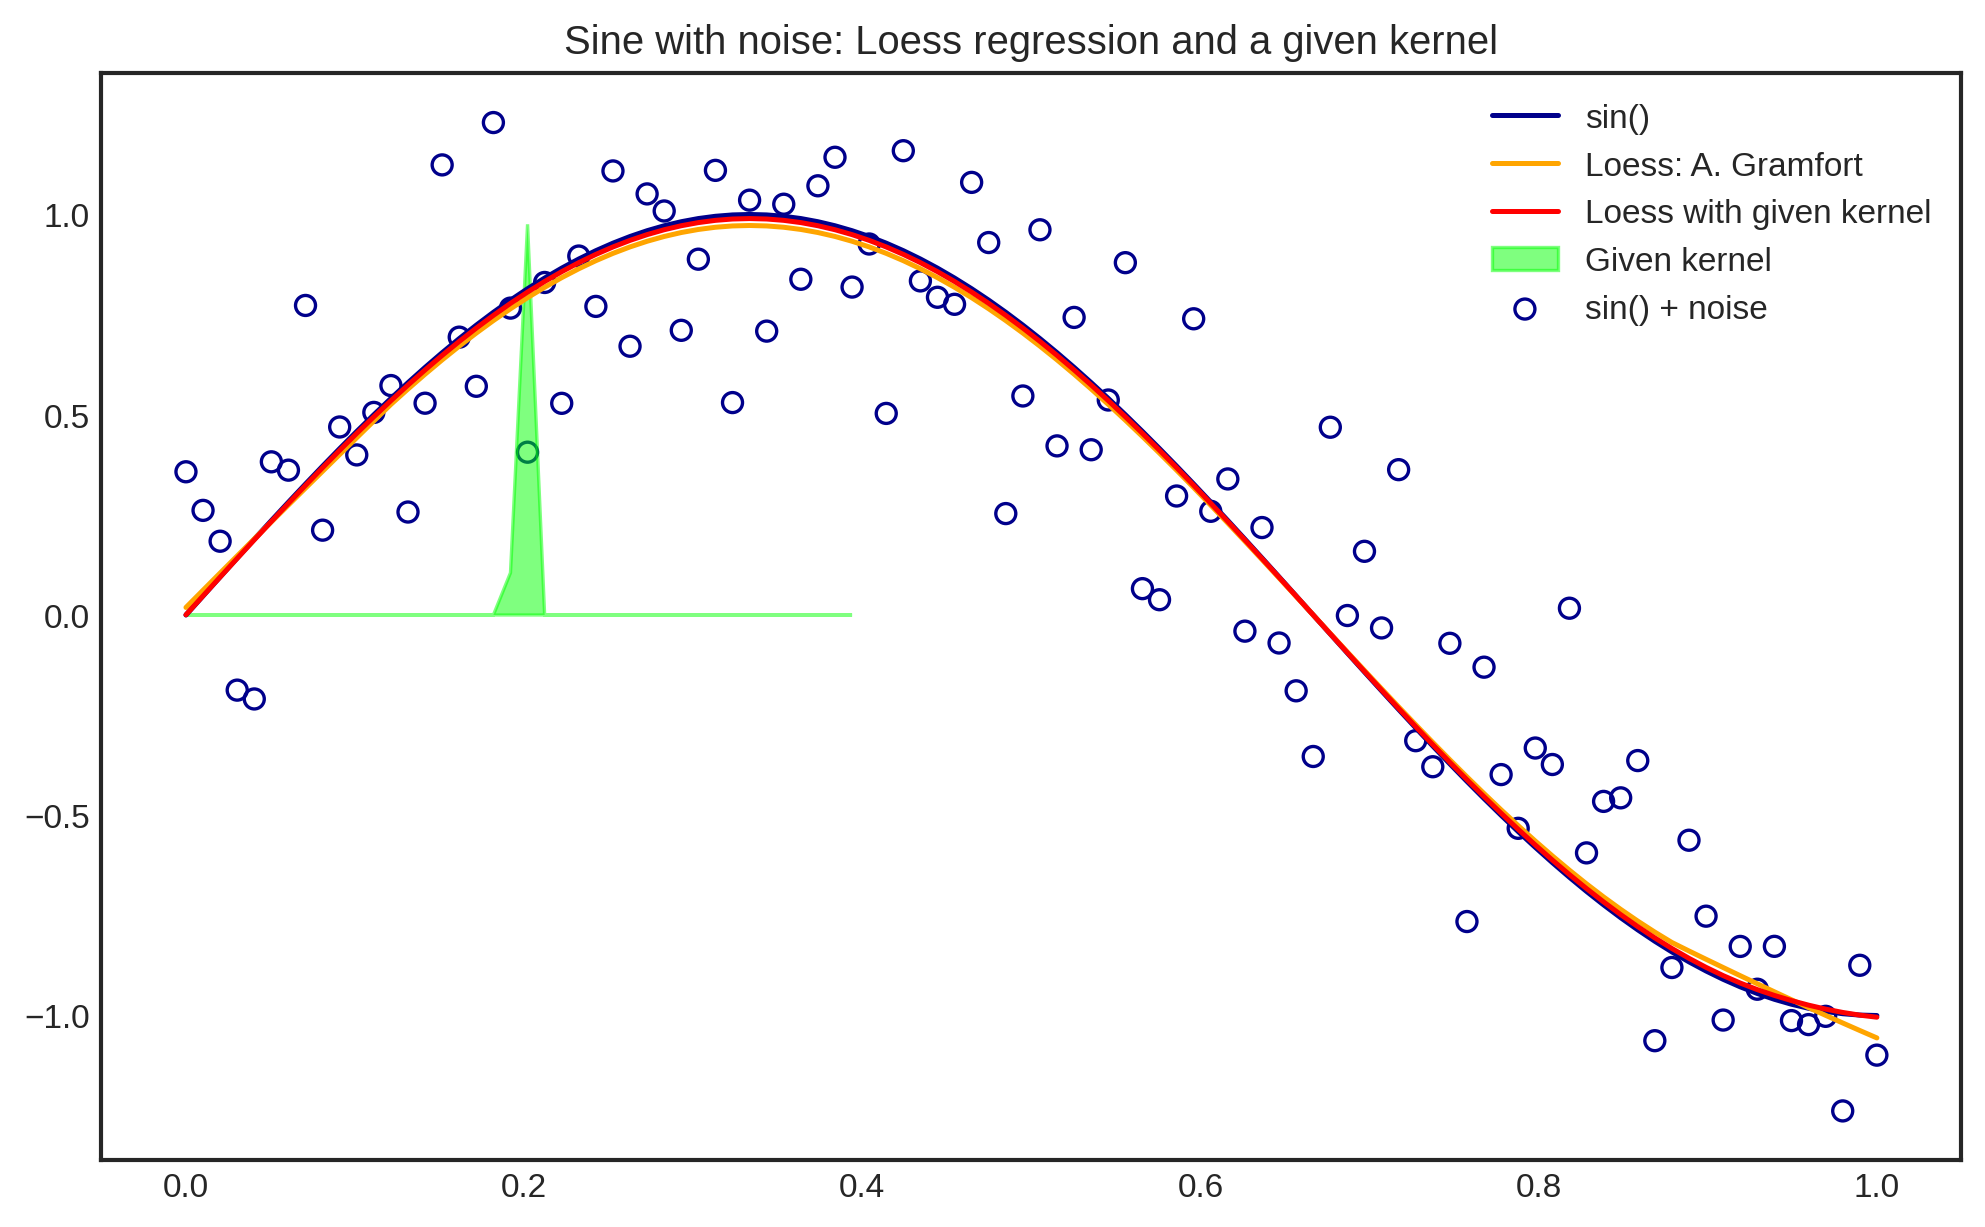

In [88]:
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'sin()')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin() + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,kernel,.005), color = 'lime', alpha = .5, label = 'Given kernel')
plt.plot(x,yest1,color = 'orange', label = 'Loess: A. Gramfort')
plt.plot(x,yest2,color = 'red', label = 'Loess with given kernel')
plt.legend()
plt.title('Sine with noise: Loess regression and a given kernel')
plt.show()

## Another example

In [74]:
#Initializing noisy non linear data
x = np.linspace(0,4,400)
noise = np.random.normal(loc = 0, scale = .8, size = 400)
y = np.sin(x**2 * 1.5 * np.pi ) 
y_noise = y + noise

In [75]:
xlr = x.reshape(-1,1)
y_noiselr = y_noise.reshape(-1,1)

In [76]:
lr = LinearRegression()
lr.fit(xlr,y_noiselr)

LinearRegression()

In [77]:
# we want to compare with linear regression
yhat_lr = lr.predict(xlr)

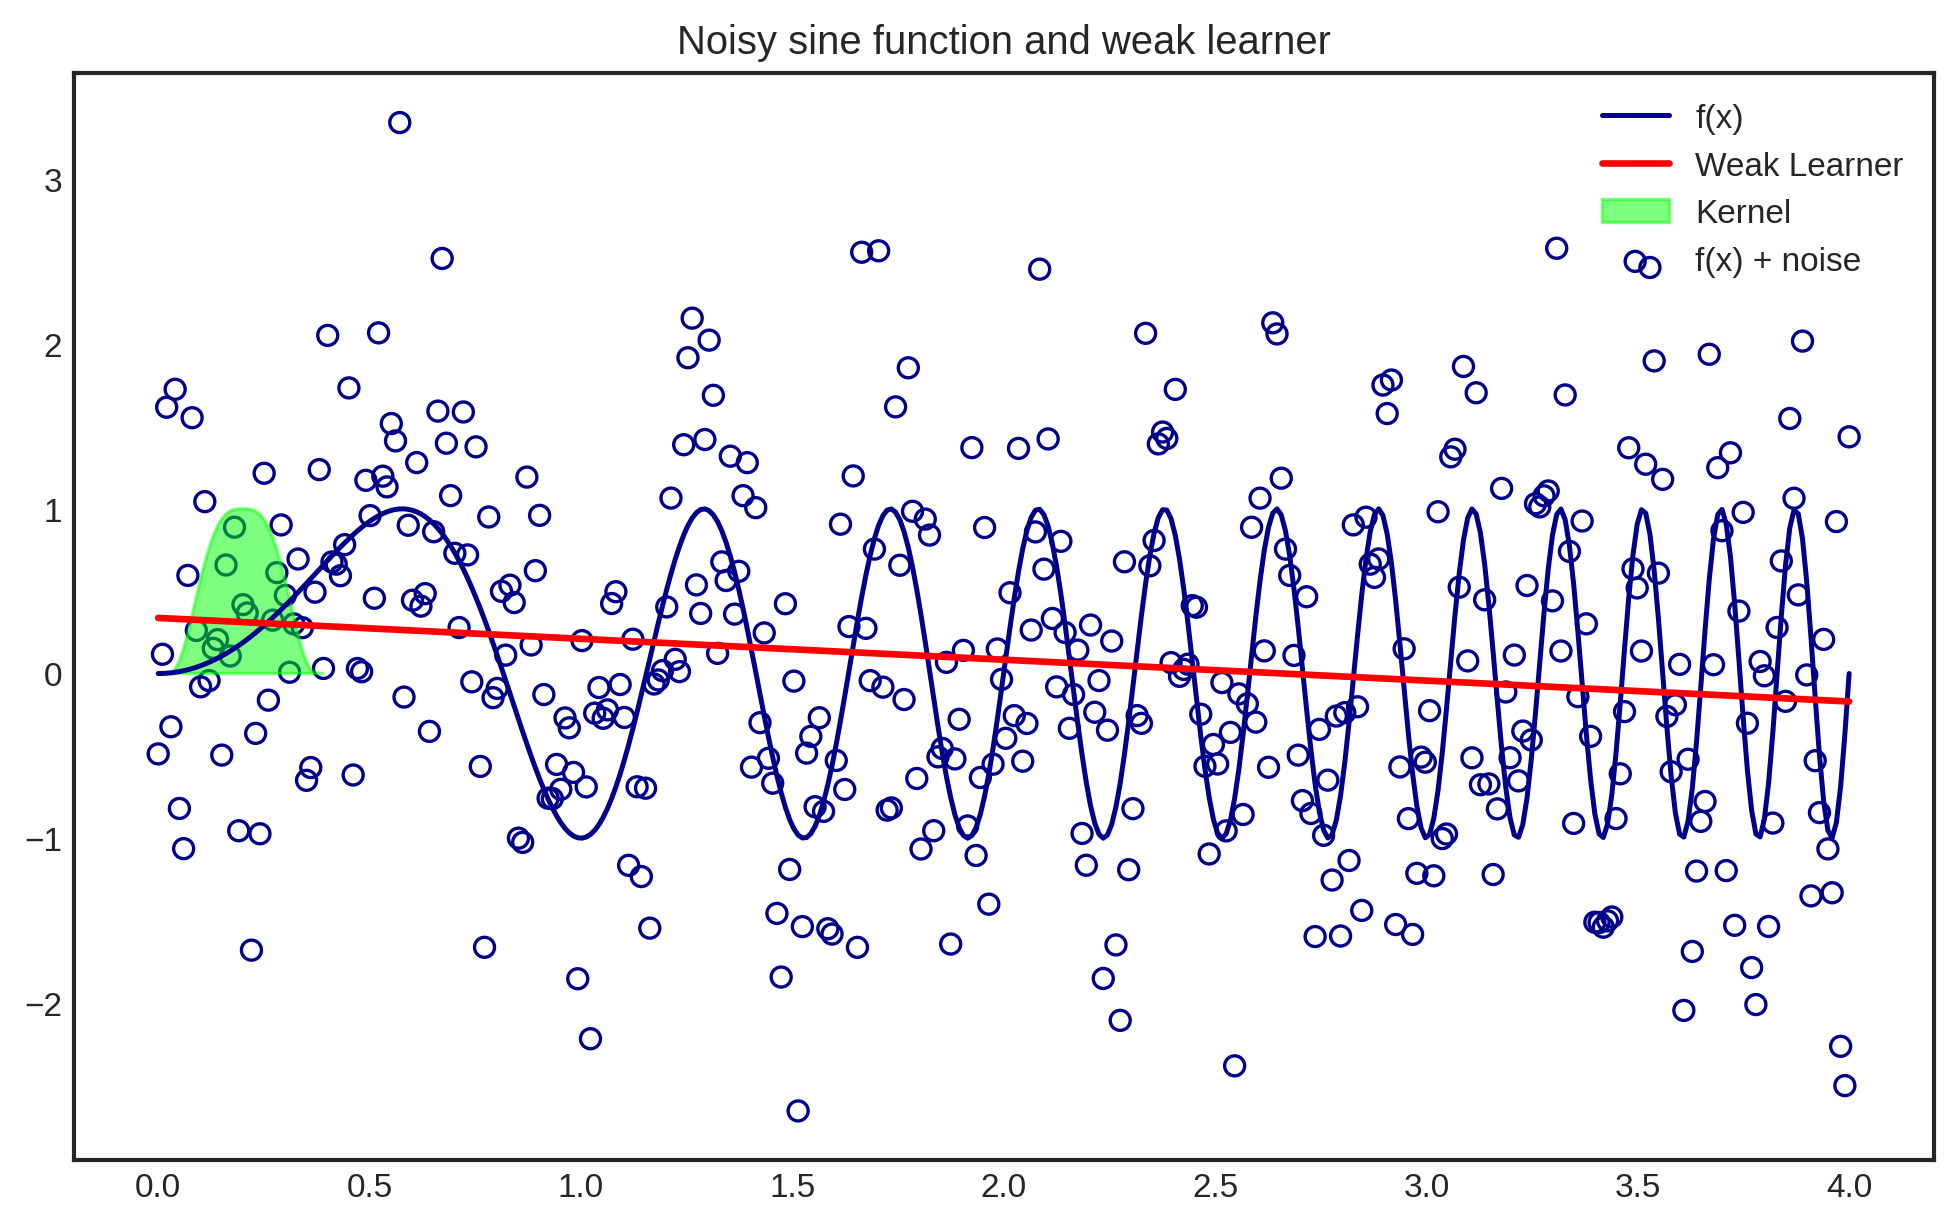

In [78]:
#Plotting the noisy data and the kernell at around x = 0.2
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'f(x)')
plt.plot(xlr,yhat_lr,color='red',lw=2,label = 'Weak Learner')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'f(x) + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,tricubic,.09), color = 'lime', alpha = .5, label = 'Kernel')
plt.legend()
plt.title('Noisy sine function and weak learner')
plt.show()

In [80]:
## here is where we make predictions with our kernel
tau = 0.009

yhat_kern = lowess(x,y,tricubic,tau)

f = 0.02
yest = lowess_ag(x, y, f=f, iter=3)

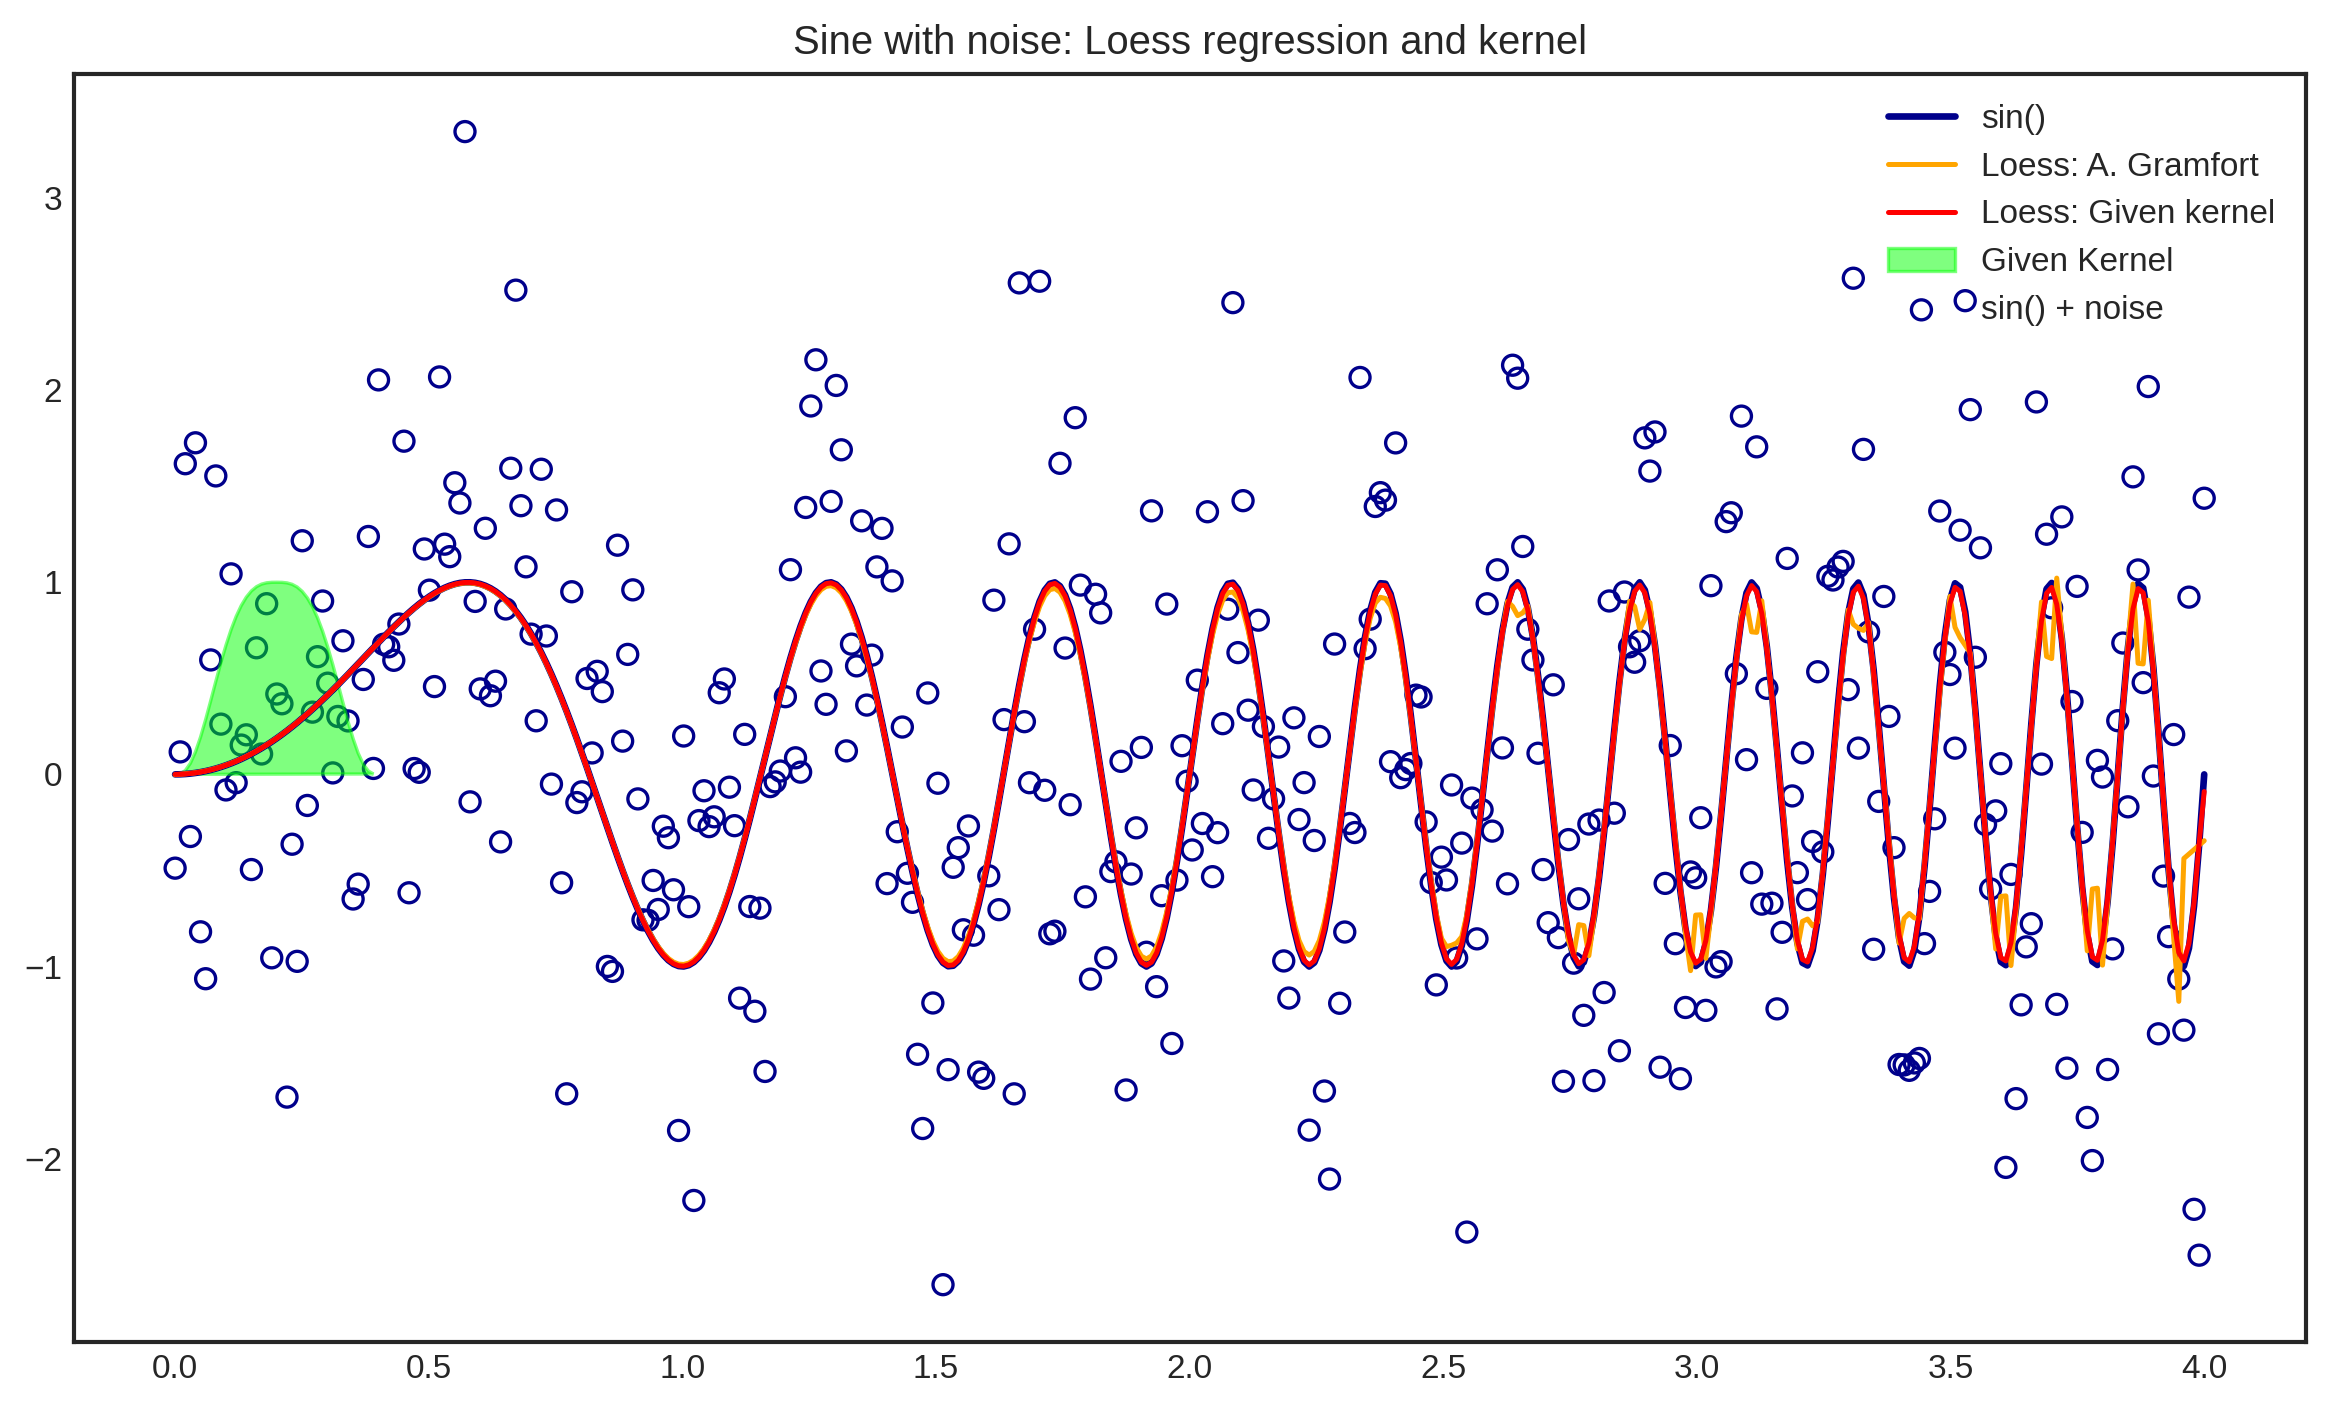

In [83]:
plt.figure(figsize=(12,7))
plt.plot(x,y,color = 'darkblue', label = 'sin()',lw=2)
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin() + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,tricubic,0.1), color = 'lime', alpha = .5, label = 'Given Kernel')
plt.plot(x,yest,color = 'orange', label = 'Loess: A. Gramfort')
plt.plot(x,yhat_kern,color = 'red', label = 'Loess: Given kernel')
plt.legend()
plt.title('Sine with noise: Loess regression and kernel')
plt.show()